Import all needed libraries

In [2]:
import re
import nltk
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

Tokenizing function:

This function gets a list of texts and tokenize each text, remove stopwords and do stemming on tokens

In [3]:
def tokenize_filtering(list_of_contexts):
    all_tokens = []         # a list to save all of tokens of all documents
    for i, doc in enumerate(list_of_contexts):
        lower_doc = doc.lower()              # make all of contexts lower case
        list_of_contexts[i] = lower_doc          
        tokens = re.findall(r'\d+(?:,\d+)*(?:\.\d+)?|\w+', list_of_contexts[i])   # tokenize the text with regex
        all_tokens.append(tokens)
    stemmer = nltk.stem.PorterStemmer()
    for i, doc in enumerate(all_tokens):
        new_tokens = []
        for token in doc:     # delete all of stopwords and single character tokens except numbers from token list
            if (len(token) < 2 and token.isalpha()) or (token in stop_words):          
                continue
            else:
                new_tokens.append(token)
        # stemming each token
        new_tokens = [stemmer.stem(token) for token in new_tokens]
        all_tokens[i] = new_tokens

    return all_tokens       # return a 2D array with contains lists of tokens of each document

# Download the stopwords
nltk.download('stopwords')
nltk.download('punkt')
# Get the list of stopwords for English
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading dataset

In [4]:
def dataset_processing(dataset):    

    list_of_contexts = []      # all of file's contexts
    for doc in dataset:                            # do for each document in a block
        context = "" 
        with open(doc, 'r', encoding='cp437') as f:  
            context = f.read()      # reading all files
            list_of_contexts.append(context)

    all_tokens = tokenize_filtering(list_of_contexts)          # list of all tokens in the dataset

    return all_tokens

TF-IDF 

In [33]:
def build_term_id(all_tokens):
    termID = []
    for doc in all_tokens:               # create a list of all unique terms in collection
        for term in doc:
            if term not in termID:    # if the term is not already in the list
                termID.append(term)

    return termID

In [34]:
def calculate_TF(tf, option, max_tf_d, max_tf_t):
    if option==1:   # binary model {0, 1}
        if tf>0:    
            return 1
        return 0
    elif option==2:    # n: TF_t,d
        return tf
    elif option==3:    # l: 1+log(TF)
        if tf>0:
            return 1 + math.log2(tf)
        return 0.1
    elif option==4:     # m: ntf
        return 0.4 + 0.6*((tf)/(max_tf_d))
    else:               # a
        return 0.5 + 0.5*((tf)/(max_tf_t))

In [35]:
def build_term_document_matrix(all_tokens, termID, option):
    term_doc = np.zeros((len(termID), len(all_tokens)))  # an empy matrix rows=len(terms) and columns=len(collection)
    # build term-doc matrix
    for i, doc in enumerate(all_tokens):
        for term in doc:
            try:   # if term is happened in the termID map
                term_ind = termID.index(term)     # row
                doc_ind = i                       # column
                term_doc[term_ind][doc_ind] += 1  # increase the frequency of the term in the document
            except:
                continue
    
    max_tf_row = []
    max_tf_col = []
    for i in range(len(term_doc)):             # find TF_max in each document and TF_max for each term
        max_tf_row.append(max(term_doc[i]))
    for j in range(len(term_doc[0])):
        col = []
        for i in range(len(term_doc)):
            col.append(term_doc[i][j])
        max_tf_col.append(max(col))

    for i in range(len(term_doc)):            # update term-doc weights based on given option
        for j in range(len(term_doc[i])):
            max_tf_t = max_tf_row[i]
            max_tf_d = max_tf_col[j]
            tf = term_doc[i][j]
            term_doc[i][j] = calculate_TF(tf, option, max_tf_d, max_tf_t)
        
    return term_doc


In [36]:
# calculate idf based on given algorithm
def calculate_IDF(N, DF_t, option):
    if option == 1:  # n
        return 1
    elif option==2:   # t
        return math.log2(N/DF_t)
    else:   # p
        return max(0, math.log2((N - DF_t)/(DF_t)))

In [37]:
def build_idf(all_tokens, term_ID, option):
    idf = np.zeros(len(term_ID))

    for i, term in enumerate(term_ID):
        count = 0
        for doc in all_tokens:     # if term happened in document i, increase doc frequency of it
            if term in doc:
                count += 1

        idf_t = calculate_IDF(len(all_tokens), count, option)   # calculate idf_t and put it in list of idfs
        idf[i] = idf_t

    return idf

Save address of files

In [5]:
def get_files_addresses(path):
    address_list = []
    os.chdir(path) 
    for file in os.listdir():                # save the file passes in a list
        file_path = f"{path}\{file}"
        address_list.append(file_path)
    
    return address_list

Find unique terms in given documents

In [6]:
def find_unique_terms(pos_tokens, neg_tokens):
    vocab = {}       # a dictionary that maps each term with its frequency (TF)
    voc_list = []    # list of all unique terms for ID mapping

    for doc in pos_tokens:
        for w in doc:
            if w not in vocab:
                # the value of each element in vocabulary dictionary is a list with 2 numebrs.
                # the first number is TF in positive data and the second one is TF in negative data
                vocab[w] = [1, 0]  
                voc_list.append(w)   # add new word 
            else:
                vocab[w][0] += 1   # add counter of the word

    for doc in neg_tokens:
        for w in doc:
            if w not in vocab:
                vocab[w]  = [0, 1]
                voc_list.append(w)
            else:
                vocab[w][1] += 1

    return vocab, voc_list

Main code

In [7]:
path_train_pos = "C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\aclImdb_v1\\aclImdb\\train\\pos" 
path_train_neg = "C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\aclImdb_v1\\aclImdb\\train\\neg" 
path_test_pos = "C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\aclImdb_v1\\aclImdb\\test\\pos" 
path_test_neg = "C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\aclImdb_v1\\aclImdb\\test\\neg" 

list_of_train_pos_address = get_files_addresses(path_train_pos)  # list of address of positive training docs
list_of_train_neg_address = get_files_addresses(path_train_neg)  # list of address of negative training docs
list_of_test_pos_address = get_files_addresses(path_test_pos)  # list of address of positive test docs
list_of_test_neg_address = get_files_addresses(path_test_neg)  # list of address of negative test docs



In [8]:
# get the token list of each class
pos_tokens = dataset_processing(list_of_train_pos_address)
neg_tokens = dataset_processing(list_of_train_neg_address)

In [9]:
vocab, voc_list = find_unique_terms(pos_tokens, neg_tokens)  # find the vocabulary of dataset

preproccessing of test set

In [10]:
test_pos = dataset_processing(list_of_test_pos_address)          
test_neg = dataset_processing(list_of_test_neg_address)

Naive Bayes Classifier

Training

$$\sum_{w\in V}^{}\frac{TF_{w,c}+\alpha}{L_{c}+B}$$

In [11]:
def train_naive_bayes(pos_tokens, neg_tokens, vocab, alpha=0.01):
    train_matrix = {}     
    B = alpha * len(vocab)  
    len_pos = 0
    for doc in pos_tokens:
        len_pos += len(doc)
    len_neg = 0
    for doc in neg_tokens:
        len_neg += len(doc)

    len_pos += B   # length of each class documents
    len_neg += B
    
    for i, w in enumerate(vocab):
        count = vocab[w][0]
        train_matrix[w] = []
        train_matrix[w].append((count + alpha)/len_pos)   # calculate the formula for each term and save it in matrix
        count = vocab[w][1]
        train_matrix[w].append((count + alpha)/len_neg)
    
    return train_matrix

In [12]:
train_matrix = train_naive_bayes(pos_tokens, neg_tokens, vocab)    # train the dataset with naive bayes

Test

$$c_{map}=argmax_{c\in C} [log\hat{P}(c)+\sum_{1\le k\le n_{d}}^{}log\hat{P}(t_{k}|c)]$$

In [13]:
def test_naive_bayes(train_matrix, voc_list, test_pos, test_neg):
    test_eval = []
    for doc in test_pos:
        pos_label = 0
        neg_label = 0
        for w in doc:
            try:
                pos_label += math.log2(train_matrix[w][0])
                neg_label += math.log2(train_matrix[w][1])
            except:
                continue
        if pos_label > neg_label:# if probability of being pos is greather than being neg then the prediction is True, else False
            test_eval.append(1)
        else:
            test_eval.append(0)
    for doc in test_neg:
        pos_label = 0
        neg_label = 0
        for w in doc:
            try:
                pos_label += math.log2(train_matrix[w][0])
                neg_label += math.log2(train_matrix[w][1])
            except:
                continue
        if pos_label > neg_label:# if probability of being pos is less than being neg then the prediction is True, else False
            test_eval.append(0)
        else:
            test_eval.append(1)

    return test_eval
            


In [38]:
predictions = test_naive_bayes(train_matrix, voc_list, test_pos, test_neg)
TpTn = 0
for v in predictions:
    TpTn += v
Tp = 0
for v in predictions[:12500]:
    Tp += v
Fp = 0
for v in predictions[12500:]:
    Fp += (1-v)
Fn = 12500 - Tp
accuracy = (TpTn/len(predictions))*100
precision = (Tp/(Tp+Fp))*100
recall = (Tp/(Tp+Fn))*100
F1 = (2*precision*recall)/(precision+recall)

print("Naive Bayes accuracy: ", accuracy, "%")
print("Naive Bayes precision: ", precision, "%")
print("Naive Bayes recall: ", recall, "%")
print("Naive Bayes F1 score: ", F1, "%")


Naive Bayes accuracy:  79.28 %
Naive Bayes precision:  83.49194729136164 %
Naive Bayes recall:  72.992 %
Naive Bayes F1 score:  77.88970462694213 %


Word Embedding 

Word2Vec model

In [24]:
# create a Word2Vec model object with list of lists as the input
all_tokens = pos_tokens[:] + neg_tokens[:]        # save all tokens of training set in a list
model = Word2Vec(all_tokens, vector_size=500, window=5, min_count=1)        
os.chdir("C:\\Users\\ASC\\OneDrive\\Desktop\\temp\\aclImdb_v1\\aclImdb")
# save the word vectors 
model.save("word_vectors.model")

get mean of vectors of each words in each document and set an document vector

In [21]:
def doc_vectorize(words_vectors, tokens):
    doc_vectors = []
    for doc in tokens:
        vectors = []
        for w in doc:
            try:
                vectors.append(words_vectors.wv[w])
            except:
                continue
        doc_vectors.append(np.mean(vectors, axis=0))

    return doc_vectors


Create word embedding using the model

In [25]:
mean_embedding_vectorizer_train = doc_vectorize(model, all_tokens)  # vectorizing documents in training set

test_tokens = test_pos[:] + test_neg[:]
mean_embedding_vectorizer_test = doc_vectorize(model, test_tokens)  # vectorizing documents in test set

In [26]:
arr = []
for i in range(12500):
    arr.append(1)
for i in range(12500):
    arr.append(0)
# create trian and test data and set labels for prediction
train_vectors = np.array(mean_embedding_vectorizer_train) 
test_vectors = np.array(mean_embedding_vectorizer_test)
train_labels = np.array(arr)
test_labels = np.array(arr)

Show word representation

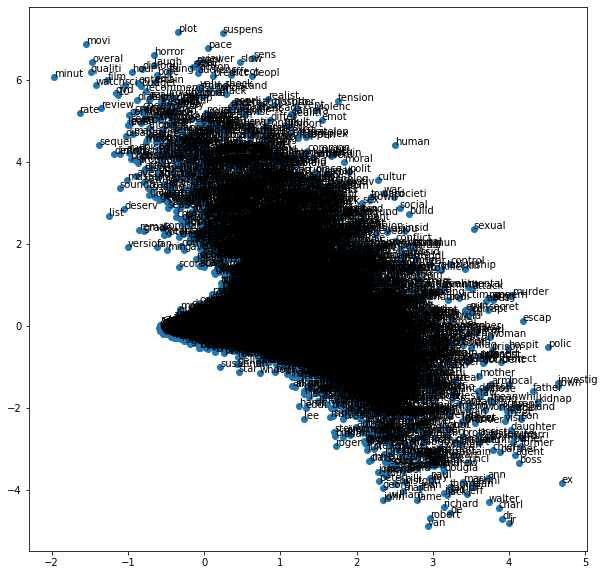

In [32]:
from sklearn.decomposition import PCA

vectors_rep = np.array([model.wv[word] for word in voc_list])

# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors_rep)

plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
# Add the words as labels to the plot
for i, word in enumerate(voc_list):
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))
plt.show()

LSA

Transform data using SVD

In [29]:
#Perform SVD on the train vectors
svd = TruncatedSVD(n_components=50) #Reduce the dimensionality to 10
train_vectors_reduced = svd.fit_transform(train_vectors) #Transform the train vectors

#Perform SVD on the test vectors
test_vectors_reduced = svd.transform(test_vectors) #Transform the test vectors

SVM

Classifying test set using svm

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
#Train a SVM classifier on the reduced train vectors
svm = LinearSVC()
svm.fit(train_vectors_reduced, train_labels)
#Predict the labels of the test vectors
test_predictions = svm.predict(test_vectors_reduced)

#Evaluate the accuracy of the classifier
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
print("SVM accuracy:", (test_accuracy*100), "%")
print("SVM precision:", (test_precision*100), "%")
print("SVM recall:", (test_recall*100), "%")
print("SVM F1:", (test_f1*100), "%")

SVM accuracy: 80.516 %
SVM precision: 80.52332559814356 %
SVM recall: 80.50399999999999 %
SVM F1: 80.51366163939674 %
